In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.pyplot import figure, show
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.metrics import mean_squared_error

In [2]:
#feePerc <- 0.0015 #fixed const for the competition
#longThresh <- 0.002 #the value the prediction has to be higher than
#longRemainWindow <- 12 #the number of hours to remain in a trade


In [3]:
df = pd.read_csv("C:/Users/saurabh/Desktop/Datathon/Data/melbdatathon2019_buylowsellhigh/training_set.csv")

In [4]:
df.count()

Unnamed: 0           1856917
keys_pair            1856917
minutesSinceStart    1856917
gap                  1856917
barClosePrice        1856917
tradePrice           1856917
Lpred1b              1856917
Lpred2b              1856917
Lpred3b              1856917
Lpred4b              1856917
Lpred5b              1856917
Lpred6b              1856917
Lpred7b              1856917
Lpred8b              1856917
Lpred9b              1856917
Lpred10b             1856917
Lpred11b             1856917
Lpred12b             1856917
Lpred13b             1856917
Lpred14b             1856917
dtype: int64

In [5]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [6]:
df = df.sample(20000)

In [7]:
df.describe()

,minutesSinceStart,gap,barClosePrice,tradePrice,Lpred1b,Lpred2b,Lpred3b,Lpred4b,Lpred5b,Lpred6b,Lpred7b,Lpred8b,Lpred9b,Lpred10b,Lpred11b,Lpred12b,Lpred13b,Lpred14b
count,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,351921.184000,0.00535,536.236303,536.241060,-0.000138,-0.000290,-0.000430,-0.000555,-0.000674,-0.000781,-0.000967,-0.001332,-0.001662,-0.002172,-0.003429,-0.004341,-0.004626,-0.004934
std,206669.950015,0.07295,1783.751958,1783.739406,0.000813,0.001190,0.001498,0.001736,0.001896,0.002060,0.002334,0.002699,0.002868,0.002958,0.002830,0.002971,0.003108,0.003194
min,5.000000,0.00000,0.000007,0.000007,-0.021184,-0.026458,-0.027700,-0.028658,-0.029604,-0.031234,-0.028987,-0.028535,-0.028674,-0.029598,-0.030739,-0.026947,-0.027101,-0.024135
25%,173923.750000,0.00000,0.000213,0.000213,-0.000445,-0.000793,-0.001102,-0.001369,-0.001593,-0.001787,-0.002131,-0.002729,-0.003213,-0.003983,-0.005456,-0.006582,-0.007011,-0.007366
50%,348972.500000,0.00000,0.014923,0.014928,-0.000151,-0.000317,-0.000463,-0.000596,-0.000732,-0.000850,-0.001040,-0.001483,-0.001863,-0.002484,-0.003617,-0.004425,-0.004700,-0.005061
75%,526175.000000,0.00000,6.580750,6.536262,0.000165,0.000206,0.000235,0.000236,0.000204,0.000177,0.000109,-0.000082,-0.000329,-0.000639,-0.001536,-0.002152,-0.002309,-0.002540
max,712650.000000,1.00000,12750.000000,12769.070000,0.012967,0.013939,0.016081,0.016634,0.018037,0.018775,0.022703,0.030022,0.038358,0.017479,0.014665,0.012909,0.011503,0.010445


In [8]:
def normalize(column):
    upper = column.max()
    lower = column.min()
    y = (column - lower)/(upper-lower)
    return y

col_normalized = normalize(df.barClosePrice)
col_normalized.describe()

count    2.000000e+04
mean     4.205775e-02
std      1.399021e-01
min      0.000000e+00
25%      1.619655e-08
50%      1.169861e-06
75%      5.161367e-04
max      1.000000e+00
Name: barClosePrice, dtype: float64

In [11]:
log_max = np.log(df.barClosePrice.max())
col_log_max_root = df.barClosePrice**(1/log_max)
col_log_max_root.describe()

count    20000.000000
mean         0.901897
std          0.668032
min          0.283894
25%          0.408943
50%          0.640948
75%          1.096571
max          2.718282
Name: barClosePrice, dtype: float64

In [12]:
col_log_max_root_normalized = normalize(col_log_max_root)
col_log_max_root_normalized.describe()

count    20000.000000
mean         0.253864
std          0.274415
min          0.000000
25%          0.051368
50%          0.146671
75%          0.333832
max          1.000000
Name: barClosePrice, dtype: float64

In [13]:
col_hyperbolic_tangent = np.tanh(df.barClosePrice)
col_hyperbolic_tangent.describe()

count    20000.000000
mean         0.287620
std          0.426077
min          0.000007
25%          0.000213
50%          0.014921
75%          0.811528
max          1.000000
Name: barClosePrice, dtype: float64

In [14]:
size = len(df.barClosePrice)-1
col_percentile_linearization = df.barClosePrice.rank(method='min').apply(lambda x: (x-1)/size)
col_percentile_linearization.describe()

count    20000.000000
mean         0.499990
std          0.288703
min          0.000000
25%          0.250000
50%          0.500000
75%          0.750000
max          1.000000
Name: barClosePrice, dtype: float64

In [15]:
col_cube_root = df.barClosePrice**(1/3)
col_cube_root.describe()

count    20000.000000
mean         2.580484
std          5.111084
min          0.018917
25%          0.059747
50%          0.246196
75%          1.457621
max         23.361644
Name: barClosePrice, dtype: float64

In [16]:
col_cube_root_normalized = normalize(col_cube_root)
col_cube_root_normalized.describe()

count    20000.000000
mean         0.109737
std          0.218958
min          0.000000
25%          0.001749
50%          0.009737
75%          0.061634
max          1.000000
Name: barClosePrice, dtype: float64

In [17]:
def sigmoid(x):
    e = np.exp(1)
    y = 1/(1+e**(-x))
    return y

col_sigmoid = sigmoid(df.barClosePrice)
col_sigmoid.describe()

count    20000.000000
mean         0.634917
std          0.212923
min          0.500002
25%          0.500053
50%          0.503731
75%          0.793840
max          1.000000
Name: barClosePrice, dtype: float64

In [18]:
col_log = np.log(df.barClosePrice + 1)
col_log.describe()

count    20000.000000
mean         1.595402
std          2.840688
min          0.000007
25%          0.000213
50%          0.014812
75%          1.307304
max          9.453365
Name: barClosePrice, dtype: float64

df.skew(axis = 0, skipna = True) 

In [19]:
#target = df['tradePrice']
features = df.drop(['gap','keys_pair', 'barClosePrice', 'tradePrice', 'minutesSinceStart'], axis=1)
#target = ['col_percentile_linearization','col_log_max_root_normalized', 'col_hyperbolic_tangent', 'col_log_max_root', 'col_cube_root', 'col_cube_root_normalized', 'col_normalized', 'col_log']
#for i in target:
    
#target = df['barClosePrice']

In [83]:
target = col_log_max_root_normalized

In [84]:
# scaling the features using standard scaler
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
features = scaler.fit_transform(features)

In [85]:
features

array([[ 1.53328349,  1.70290811,  1.59445598, ...,  1.43448923,
         1.6628189 ,  1.72735374],
       [ 0.40243323,  0.43919425,  0.43181663, ...,  1.27141439,
         1.37348579,  1.52191194],
       [-0.28525201, -0.33313963, -0.30910623, ...,  0.46254825,
         0.61765216,  0.77247003],
       ...,
       [-0.2516198 , -0.05081984,  0.31716041, ...,  1.67300817,
         1.70214689,  1.51265641],
       [-0.213779  , -0.27105684, -0.32584485, ..., -0.30845758,
        -0.47287966, -0.47442822],
       [-0.35534043, -0.06925181,  0.06572893, ..., -0.84039598,
        -0.85218848, -0.85889582]])

In [86]:
#spliting the training and testing data, keeping 20% for testing and rest for training. 
from sklearn.model_selection import train_test_split
features_train, features_test, target_train, target_test = train_test_split(features, col_hyperbolic_tangent, test_size = 0.20, random_state = 42) 

In [87]:
from sklearn.base import BaseEstimator, TransformerMixin

# custom function for RFI feature selection inside a pipeline
# here we use n_estimators=100
class RFIFeatureSelector(BaseEstimator, TransformerMixin):
    
    # class constructor 
    # make sure class attributes end with a "_"
    # per scikit-learn convention to avoid errors
    def __init__(self, n_features_=100):
        self.n_features_ = n_features_
        self.fs_indices_ = None

    # override the fit function
    def fit(self, X, y):
        from sklearn.ensemble import RandomForestRegressor
        from numpy import argsort
        model_rfi = RandomForestRegressor(n_estimators=100)
        model_rfi.fit(X, y)
        self.fs_indices_ = argsort(model_rfi.feature_importances_)[::-1][0:self.n_features_] 
        return self 
    
    # override the transform function
    def transform(self, X, y=None):
        return X[:, self.fs_indices_]

In [88]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


rf_regressor = RandomForestRegressor(random_state=999)

pipe_RF = Pipeline([('rfi_fs', RFIFeatureSelector()),
                    ('rf', rf_regressor)])



params_pipe_RF = {'rfi_fs__n_features_': [features.shape[1]],                  
                  'rf__max_depth': [10], 
                  'rf__min_samples_split': [2]}
 
    


gs_pipe_RF  = GridSearchCV(estimator=pipe_RF, 
                           param_grid=params_pipe_RF, 
                           cv=5,
                           n_jobs=-1,
                           scoring= 'neg_mean_squared_error', 
                           verbose=1)

gs_pipe_RF.fit(features_train, target_train);

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   49.2s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   52.0s finished
C:\Users\saurabh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Wall time: 1min 48s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('rfi_fs',
                                        RFIFeatureSelector(n_features_=100)),
                                       ('rf',
                                        RandomForestRegressor(bootstrap=True,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                                                              min_samples_leaf=1,
                                                              min_samp

In [89]:
features.shape

(20000, 14)

In [90]:
# Grid search has returned following best paramenters and score
print('Best Grid Score:', gs_pipe_RF.best_score_)
print('Best Parameters:', gs_pipe_RF.best_params_)

Best Grid Score: -0.10124813915731054
Best Parameters: {'rf__max_depth': 10, 'rf__min_samples_split': 2, 'rfi_fs__n_features_': 14}


In [91]:
import joblib
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
joblib.dump(gs_pipe_RF.best_estimator_, 'best_rf.pkl', compress = 1)
Best_Model = joblib.load('best_rf.pkl')

target_test_pred = Best_Model.predict(features_test)
target_train_pred = Best_Model.predict(features_train)

# test error
print("test error: RMSE ",np.sqrt(mean_squared_error(target_test_pred, target_test)))

# test error
print("test error: MAE ",mean_absolute_error(target_test_pred, target_test))

# training error
print("training error: RMSE ",np.sqrt(mean_squared_error(target_train_pred, target_train)))

test error: RMSE  0.32399434545273964
test error: MAE  0.22408464932004893
training error: RMSE  0.26378328202048473


In [1384]:
# Use the model's prediction for validation set
validation_df = pd.read_csv("C:/Users/saurabh/Desktop/Datathon/Data/melbdatathon2019_buylowsellhigh/public_set.csv")


In [1385]:
validation_df = validation_df.iloc[3000001:, : ]

In [1386]:
# remove the first column as it was unnamed and off no use
validation_df = validation_df.loc[:, ~validation_df.columns.str.contains('^Unnamed')]
validation_features = validation_df.drop(['gap','keys_pair', 'barClosePrice', 'tradePrice', 'minutesSinceStart'], axis=1)
validation_features_scaled = scaler.fit_transform(validation_features)


In [1387]:
predictions = pd.DataFrame()
predictions['keys_pair'] = validation_df['keys_pair']
predictions['minutesSinceStart'] = validation_df['minutesSinceStart']
#predictions['tradePrice'] = validation_df['tradePrice']
#predictions['target'] = (validation_target)
prediction  = Best_Model.predict(validation_features_scaled)
predictions['model_prediction'] = (prediction)

In [1388]:
difference_df = pd.DataFrame()
difference_df['keys_pair'] = predictions['keys_pair']
difference_df['enterTime'] = predictions['minutesSinceStart']
difference_df['model_prediction'] = predictions['model_prediction']
difference_df['enterPrice'] = predictions['model_prediction']
keys_pair_group = predictions.groupby(['keys_pair'])   


In [1389]:
%%time
col_names = []
diff_range = 1152                             
for pairs in keys_pair_group:
    for i in range(1, diff_range+1):
        col_names.append(str(i))
        difference_df[str(i)] = predictions['model_prediction'].diff(i).shift(periods=-i)
    difference_df['d_id_max'] = difference_df[col_names].idxmax(axis=1)      

Wall time: 9.73 s


In [1390]:
difference_df.head()

,keys_pair,enterTime,model_prediction,enterPrice,1,2,3,4,5,6,...,1144,1145,1146,1147,1148,1149,1150,1151,1152,d_id_max
3000001,pair_22,451015.0,0.041386,0.041386,0.000000,0.000000,0.000000,0.000000,0.003276,0.000000,...,-0.015521,-0.013343,-0.013343,-0.013343,-0.013343,-0.013343,-0.013343,-0.013343,-0.013343,289
3000002,pair_22,451020.0,0.041386,0.041386,0.000000,0.000000,0.000000,0.003276,0.000000,0.003276,...,-0.013343,-0.013343,-0.013343,-0.013343,-0.013343,-0.013343,-0.013343,-0.013343,-0.013343,288
3000003,pair_22,451025.0,0.041386,0.041386,0.000000,0.000000,0.003276,0.000000,0.003276,0.000000,...,-0.013343,-0.013343,-0.013343,-0.013343,-0.013343,-0.013343,-0.013343,-0.013343,-0.013343,287
3000004,pair_22,451030.0,0.041386,0.041386,0.000000,0.003276,0.000000,0.003276,0.000000,0.000000,...,-0.013343,-0.013343,-0.013343,-0.013343,-0.013343,-0.013343,-0.013343,-0.013343,-0.013343,286
3000005,pair_22,451035.0,0.041386,0.041386,0.003276,0.000000,0.003276,0.000000,0.000000,0.000000,...,-0.013343,-0.013343,-0.013343,-0.013343,-0.013343,-0.013343,-0.013343,-0.013343,-0.013343,285


In [1391]:
difference_df =difference_df.fillna(0)

In [1394]:
df1 = difference_df.iloc[:, 5:1156]
mask = df1.le(difference_df['enterPrice']* -0.05, axis=0)
difference_df['d_id_max'] = np.where(mask.all(axis=1), mask.idxmax(axis=1), df1.idxmax(axis=1))

In [1396]:
difference_df["d_id_max"] = difference_df["d_id_max"].astype('int64')

In [1397]:
difference_df['exitTime'] = difference_df.loc[difference_df.index + difference_df.d_id_max, 'enterTime'].to_numpy()

C:\Users\saurabh\Anaconda3\lib\site-packages\pandas\core\indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


In [1398]:
difference_df['exitPrice'] = difference_df.loc[difference_df.index + difference_df.d_id_max, 'model_prediction'].to_numpy()

In [1399]:
difference_df['loss_gain'] = difference_df['exitPrice']- difference_df['model_prediction'] 

In [1400]:
difference_df['percentage_gain(%)'] = (difference_df['loss_gain']/difference_df['model_prediction'])* 100

In [1401]:
difference_df['trading_fee'] = (difference_df['model_prediction']  +  difference_df['exitPrice']) * 0.0015

In [1428]:
difference_df['loss_gain_after_trading_fee'] = difference_df['loss_gain'] - difference_df['trading_fee']

In [1430]:
difference_df['percentage_gain(%)_after_trading_fee'] = (difference_df['loss_gain_after_trading_fee']/difference_df['enterPrice'])* 100

In [1431]:
difference_df.head()

,keys_pair,enterPrice,exitPrice,enterTime,exitTime,loss_gain,percentage_gain(%),trading_fee,direction,percentPair,strategyName,loss_gain_after_trading_fee,percentage_gain(%)_after_trading_fee
3000001,pair_22,0.041386,0.565622,451015.0,452460.0,0.524236,1266.686792,0.000911,1,1,myStrategy,0.523325,1264.486761
3000002,pair_22,0.041386,0.565622,451020.0,452460.0,0.524236,1266.686792,0.000911,1,1,myStrategy,0.523325,1264.486761
3000003,pair_22,0.041386,0.565622,451025.0,452460.0,0.524236,1266.686792,0.000911,1,1,myStrategy,0.523325,1264.486761
3000004,pair_22,0.041386,0.565622,451030.0,452460.0,0.524236,1266.686792,0.000911,1,1,myStrategy,0.523325,1264.486761
3000005,pair_22,0.041386,0.565622,451035.0,452460.0,0.524236,1266.686792,0.000911,1,1,myStrategy,0.523325,1264.486761


In [1432]:
col_list = ['keys_pair', 'enterPrice', 'exitPrice','enterTime', 'exitTime', 'loss_gain_after_trading_fee', 'percentage_gain(%)_after_trading_fee' ]

In [1433]:
difference_df = difference_df[col_list]

In [1434]:
direction = [1]
percentPair = [1]
strategyName = ['myStrategy']

difference_df['direction'] = np.repeat(direction,len(difference_df))
difference_df['percentPair'] = np.repeat(percentPair,len(difference_df))
difference_df['strategyName'] = np.repeat(strategyName,len(difference_df))

C:\Users\saurabh\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\saurabh\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\saurabh\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing

In [1435]:
difference_df['loss_gain_after_trading_fee'] = difference_df[difference_df['loss_gain_after_trading_fee'] > 0]['loss_gain_after_trading_fee']
difference_df = difference_df.dropna()

C:\Users\saurabh\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [1436]:
difference_df.head(10)

,keys_pair,enterPrice,exitPrice,enterTime,exitTime,loss_gain_after_trading_fee,percentage_gain(%)_after_trading_fee,direction,percentPair,strategyName
3000001,pair_22,0.041386,0.565622,451015.0,452460.0,0.523325,1264.486761,1,1,myStrategy
3000002,pair_22,0.041386,0.565622,451020.0,452460.0,0.523325,1264.486761,1,1,myStrategy
3000003,pair_22,0.041386,0.565622,451025.0,452460.0,0.523325,1264.486761,1,1,myStrategy
3000004,pair_22,0.041386,0.565622,451030.0,452460.0,0.523325,1264.486761,1,1,myStrategy
3000005,pair_22,0.041386,0.565622,451035.0,452460.0,0.523325,1264.486761,1,1,myStrategy
3000006,pair_22,0.044662,0.565622,451040.0,452460.0,0.520044,1164.399694,1,1,myStrategy
3000007,pair_22,0.041386,0.565622,451045.0,452460.0,0.523325,1264.486761,1,1,myStrategy
3000008,pair_22,0.044662,0.565622,451050.0,452460.0,0.520044,1164.399694,1,1,myStrategy
3000009,pair_22,0.041386,0.565622,451055.0,452460.0,0.523325,1264.486761,1,1,myStrategy
3000010,pair_22,0.041386,0.565622,451060.0,452460.0,0.523325,1264.486761,1,1,myStrategy


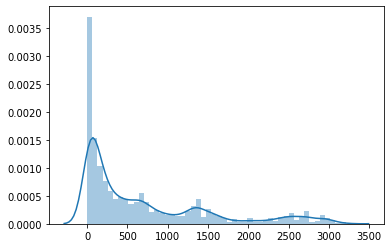

In [1439]:
mean = np.mean(difference_df['percentage_gain(%)_after_trading_fee'], axis=0)
sd = np.std(difference_df['percentage_gain(%)_after_trading_fee'], axis=0)
final_list = [x for x in difference_df['percentage_gain(%)_after_trading_fee'] if (x > mean - 2 * sd)]
final_list = [x for x in final_list if (x < mean + 2 * sd)]
sns.distplot(final_list)

In [1444]:
TPG = difference_df['percentage_gain(%)_after_trading_fee'].sum()
print(TPG)

46235000.88852434


In [1406]:
col_list = ['keys_pair', 'enterTime', 'exitTime', 'direction', 'percentPair', 'strategyName']

submission_df = pd.DataFrame()
submission_df = difference_df[col_list]

In [1407]:
submission_df['enterTime'] = submission_df['enterTime'].astype('int')
submission_df['exitTime'] = submission_df['exitTime'].astype('int')

C:\Users\saurabh\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\saurabh\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [1371]:
submission_df.to_csv("C:/Users/saurabh/Desktop/Datathon_submission/submission_df_31.csv")